<a href="https://colab.research.google.com/github/djiraffs/Deep-Learning/blob/main/Week%20UTS/Model%20CNN/UTS_Model_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

## Mengecek Data dan Membersihkan Data

In [21]:
dataset_path = '/content/drive/MyDrive/FishImgDataset'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

fish_categories = os.listdir(train_dir)
num_classes = len(fish_categories)
print(f"Kategori ikan yang ditemukan: {fish_categories}")
print(f"Jumlah kelas: {num_classes}")

Kategori ikan yang ditemukan: ['Scat Fish', 'Tenpounder', 'Silver Perch', 'Snakehead', 'Silver Barb', 'Perch', 'Tilapia', 'Pangasius', 'Silver Carp', 'Long-Snouted Pipefish', 'Mudfish', 'Knifefish', 'Green Spotted Puffer', 'Jaguar Gapote', 'Janitor Fish', 'Indian Carp', 'Mosquito Fish', 'Mullet', 'Indo-Pacific Tarpon', 'Black Spotted Barb', 'Glass Perchlet', 'Catfish', 'Freshwater Eel', 'Goby', 'Fourfinger Threadfin', 'Gold Fish', 'Grass Carp', 'Climbing Perch', 'Gourami', 'Big Head Carp', 'Bangus']
Jumlah kelas: 31


In [22]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)




Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.


In [27]:
fish_categories = os.listdir(train_dir)
num_classes = len(fish_categories)
print(f"Kategori ikan : {fish_categories}")
print(f"Banyaknya kelas: {num_classes}")

Kategori ikan : ['Scat Fish', 'Tenpounder', 'Silver Perch', 'Snakehead', 'Silver Barb', 'Perch', 'Tilapia', 'Pangasius', 'Silver Carp', 'Long-Snouted Pipefish', 'Mudfish', 'Knifefish', 'Green Spotted Puffer', 'Jaguar Gapote', 'Janitor Fish', 'Indian Carp', 'Mosquito Fish', 'Mullet', 'Indo-Pacific Tarpon', 'Black Spotted Barb', 'Glass Perchlet', 'Catfish', 'Freshwater Eel', 'Goby', 'Fourfinger Threadfin', 'Gold Fish', 'Grass Carp', 'Climbing Perch', 'Gourami', 'Big Head Carp', 'Bangus']
Banyaknya kelas: 31


In [28]:
def create_image_df(base_dir):
    image_paths = []
    labels = []

    for category in fish_categories:
        category_path = os.path.join(base_dir, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(category_path, img_name))
                    labels.append(category)

    return pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

In [29]:
import pandas as pd
train_df = create_image_df(train_dir)
val_df = create_image_df(val_dir)
test_df = create_image_df(test_dir)

print(f"Totaldata training: {len(train_df)}")
print(f"Total data validasi: {len(val_df)}")
print(f"data test: {len(test_df)}")

Totaldata training: 8673
Total data validasi: 2725
data test: 1729


In [30]:
print("\nMissing values pada data training:")
print(train_df.isnull().sum())


Missing values pada data training:
image_path    0
label         0
dtype: int64


## Feature Engineering

In [38]:
label_encoder = LabelEncoder()
label_encoder.fit(fish_categories)

category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nPembagian kategori:")
for category, code in category_mapping.items():
    print(f"{category}: {code}")


Pembagian kategori:
Bangus: 0
Big Head Carp: 1
Black Spotted Barb: 2
Catfish: 3
Climbing Perch: 4
Fourfinger Threadfin: 5
Freshwater Eel: 6
Glass Perchlet: 7
Goby: 8
Gold Fish: 9
Gourami: 10
Grass Carp: 11
Green Spotted Puffer: 12
Indian Carp: 13
Indo-Pacific Tarpon: 14
Jaguar Gapote: 15
Janitor Fish: 16
Knifefish: 17
Long-Snouted Pipefish: 18
Mosquito Fish: 19
Mudfish: 20
Mullet: 21
Pangasius: 22
Perch: 23
Scat Fish: 24
Silver Barb: 25
Silver Carp: 26
Silver Perch: 27
Snakehead: 28
Tenpounder: 29
Tilapia: 30


In [39]:
IMG_SIZE = 224
BATCH_SIZE = 32


# Data augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 8801 images belonging to 31 classes.


In [41]:
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2751 images belonging to 31 classes.


In [42]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1760 images belonging to 31 classes.


## Visualisasi


Contoh gambar dari training set:


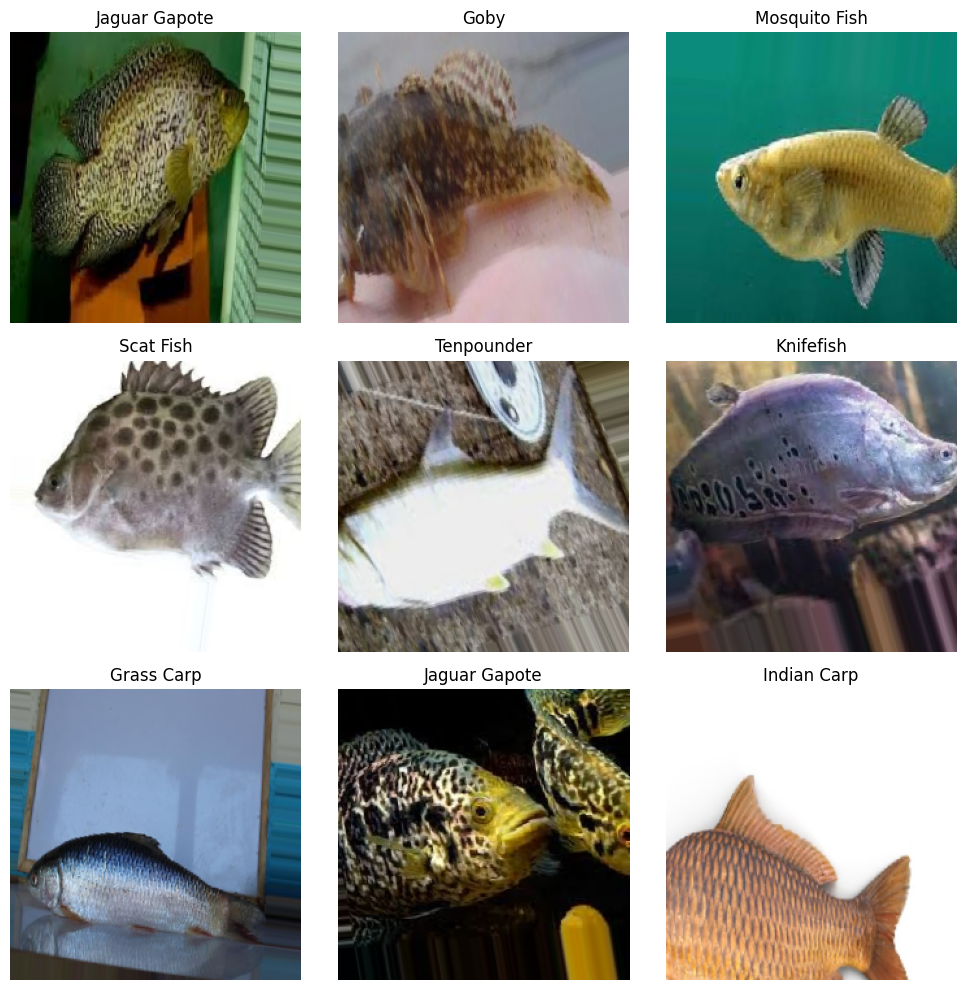

In [43]:
def visualize_samples(generator, n=9):
    plt.figure(figsize=(10, 10))
    batch = next(generator)
    images, labels = batch

    for i in range(min(n, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        class_name = list(generator.class_indices.keys())[label_idx]
        plt.title(class_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("\nContoh gambar dari training set:")
visualize_samples(train_generator)

## CNN Model

In [46]:
def create_custom_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


# Model 2: Transfer Learning dengan MobileNetV2
def create_transfer_learning_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


model = create_transfer_learning_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,887 (9.89 MB)

 Trainable params: 335,903 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [52]:
checkpoint_path = "fish_classification_model.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]



# Training model
EPOCHS = 1
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6620 - loss: 1.1412
Epoch 1: val_accuracy improved from -inf to 0.81425, saving model to fish_classification_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.6620 - loss: 1.1413 - val_accuracy: 0.8142 - val_loss: 0.6957 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


In [54]:
test_results = model.evaluate(test_generator)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 346s 6s/step - accuracy: 0.7634 - loss: 0.8198
Test Loss: 0.6915
Test Accuracy: 0.8097


In [55]:
test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

55/55 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step


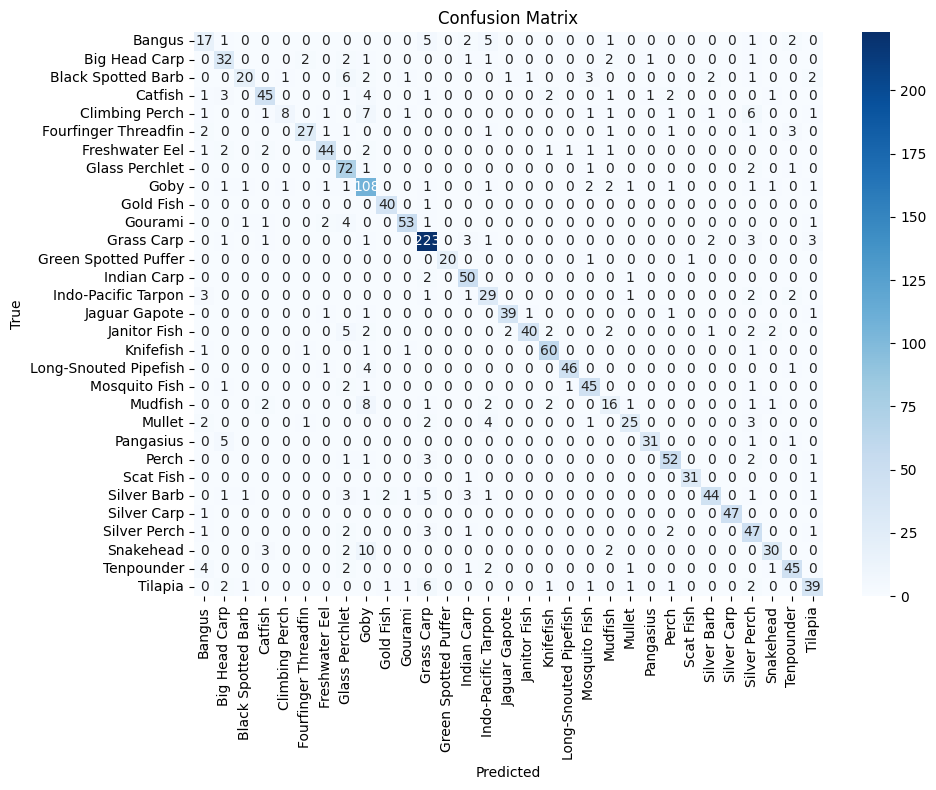

In [56]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [59]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

try:
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), y_pred_probs, multi_class='ovr')
except ValueError:
    roc_auc = "Not applicable due to class imbalance or calculation issues"


print("\nEVALUASI MODEL")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



EVALUASI MODEL
Accuracy: 0.8097
Precision: 0.8199
Recall: 0.8097
F1 Score: 0.8066
ROC AUC Score: 0.9906759193955769

Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.50      0.50      0.50        34
        Big Head Carp       0.65      0.74      0.70        43
   Black Spotted Barb       0.83      0.50      0.62        40
              Catfish       0.82      0.73      0.77        62
       Climbing Perch       0.80      0.27      0.40        30
 Fourfinger Threadfin       0.87      0.71      0.78        38
       Freshwater Eel       0.86      0.80      0.83        55
       Glass Perchlet       0.69      0.94      0.80        77
                 Goby       0.70      0.87      0.77       124
            Gold Fish       0.93      0.98      0.95        41
              Gourami       0.91      0.84      0.88        63
           Grass Carp       0.87      0.94      0.90       238
 Green Spotted Puffer       1.00      0

## ROC Curve

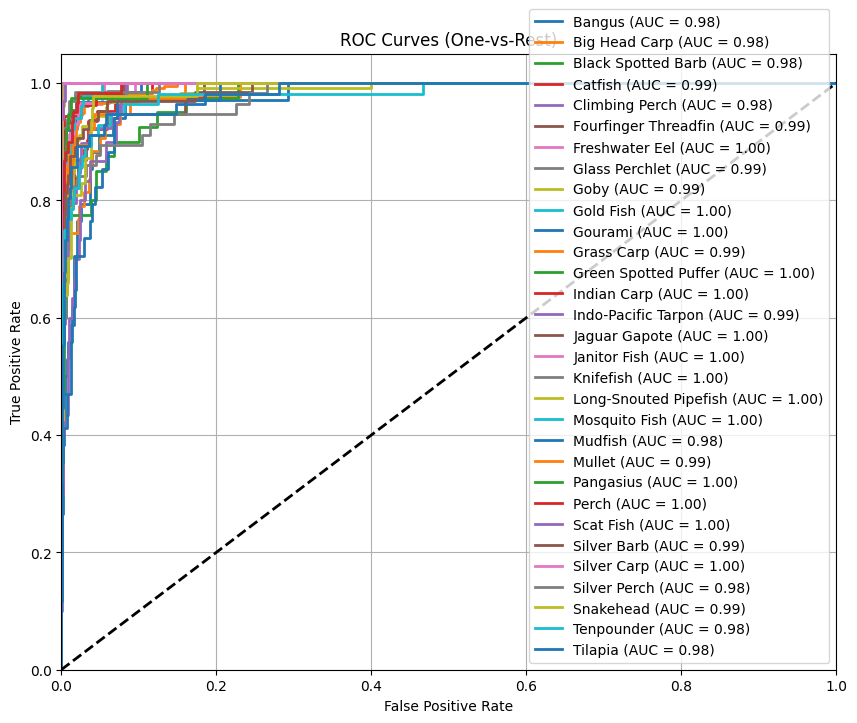

In [60]:
def plot_roc_curves(y_true, y_pred_probs, class_names):
    plt.figure(figsize=(10, 8))

    # One-hot encode true labels
    y_true_categorical = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

    # Plot ROC curve for each class
    from sklearn.metrics import roc_curve, auc
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_categorical[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


try:
    plot_roc_curves(y_true, y_pred_probs, class_names)
except Exception as e:
    print(f"Could not plot ROC curves: {e}")

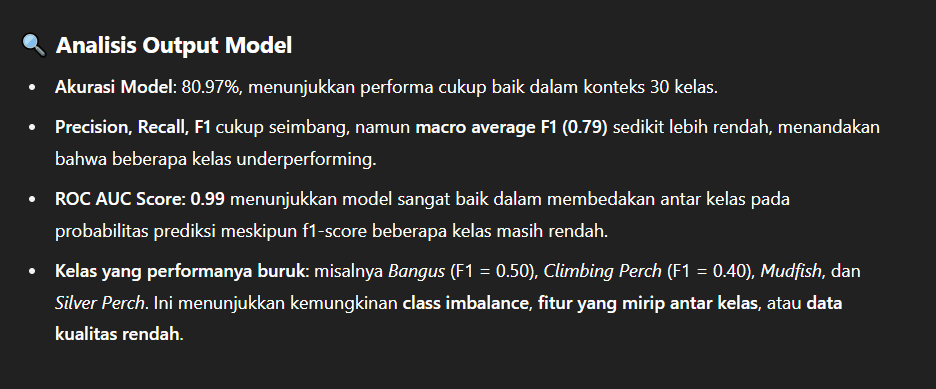

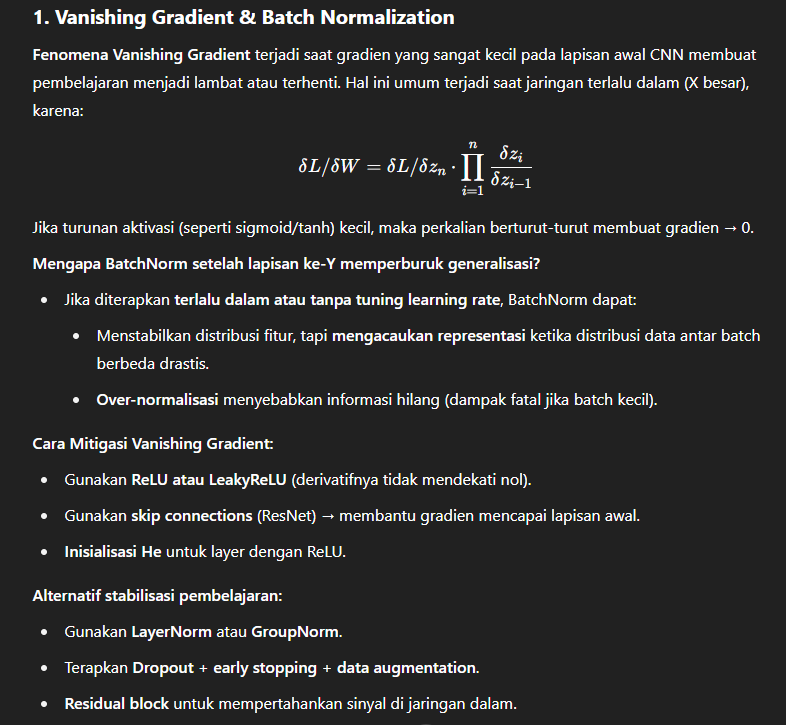

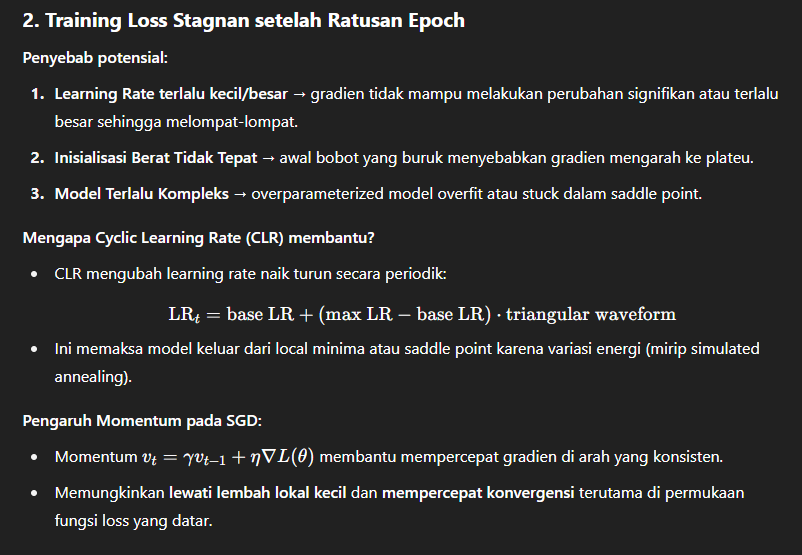

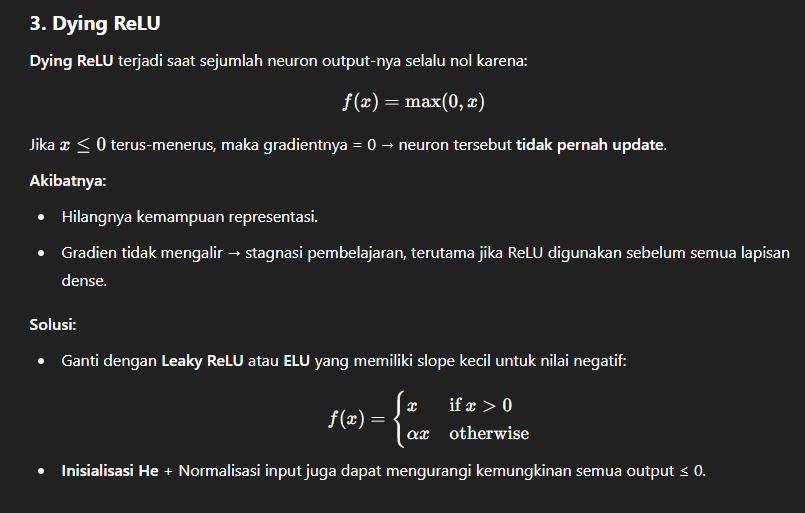

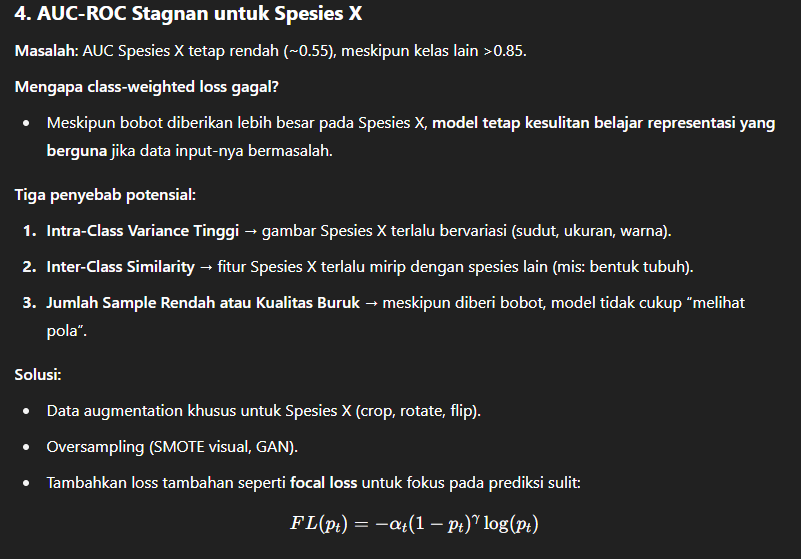

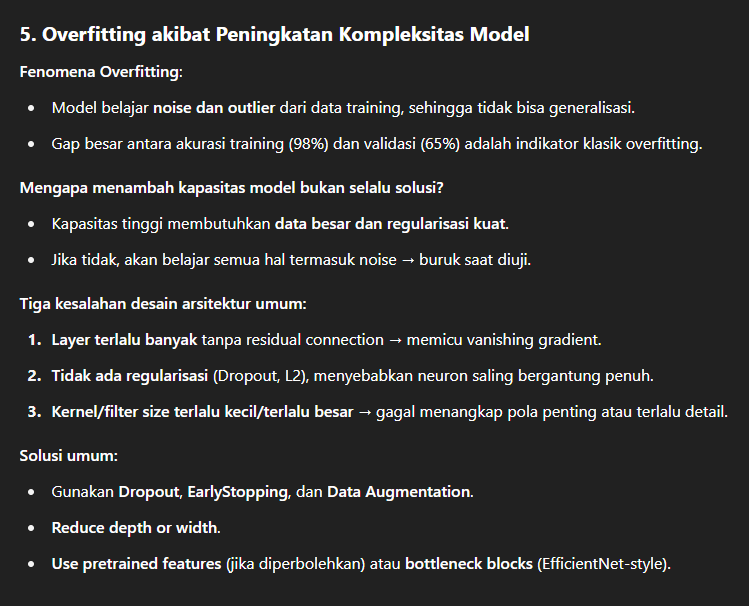